
# Image Classification fro CIFAR-10 dataset

## 1 -  1

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [2]:
# Loading the data with the use of torchvision and torch.utils.data packages

data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=data_transforms)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=False, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=4)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [3]:
dataloaders={}
dataloaders["train"] = trainloader
dataloaders["test"] = testloader

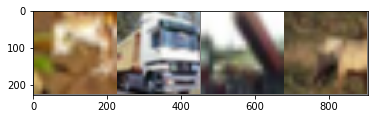

 frog truck truck  deer


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# Verifying the size
dataiter = iter(trainloader)
images, labels = dataiter.next()

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

images shape on batch size = torch.Size([32, 3, 224, 224])
labels shape on batch size = torch.Size([32])


In [6]:
dataset_sizes={}
dataset_sizes["train"]=len(trainset)
dataset_sizes["test"]=len(testset)

## 1-2

### Convnet as a feature extractor
- Freezing all the layers other than the final layer
- Freezing the gradient parameter so that the gradient is not computed backwards

    Testing Data Accuracy : 62.59%
    
#### Choices made:
- Increased the batch size to 32 and parellel processing channels to 4(to optimize the computation time)
    - Computation Time reduced by 30% (from ~100 min to ~60 min)
    - Difference in training and testing accuracies reduced toa round 1-2% from 10-15%
    
    
- Changed the Learning Rate to 0.01 (from 0.001) and Momentum to 0.5 (from 0.9) that helped to converge faster 


### Building a Training Model

In [10]:


def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode if it is a training set
            else:
                model.eval()   # Set model to evaluate mode if otherwise

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in  dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [11]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 10)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.01, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.3837 Acc: 0.5212
test Loss: 1.1957 Acc: 0.5832

Epoch 1/24
----------
train Loss: 1.2032 Acc: 0.5790
test Loss: 1.1630 Acc: 0.5931

Epoch 2/24
----------
train Loss: 1.1770 Acc: 0.5883
test Loss: 1.1439 Acc: 0.5954

Epoch 3/24
----------
train Loss: 1.1696 Acc: 0.5911
test Loss: 1.1115 Acc: 0.6089

Epoch 4/24
----------
train Loss: 1.1541 Acc: 0.5976
test Loss: 1.1011 Acc: 0.6153

Epoch 5/24
----------
train Loss: 1.1483 Acc: 0.5980
test Loss: 1.1192 Acc: 0.6043

Epoch 6/24
----------
train Loss: 1.1511 Acc: 0.5981
test Loss: 1.1135 Acc: 0.6066

Epoch 7/24
----------
train Loss: 1.1227 Acc: 0.6085
test Loss: 1.0891 Acc: 0.6140

Epoch 8/24
----------
train Loss: 1.1231 Acc: 0.6076
test Loss: 1.0888 Acc: 0.6259

Epoch 9/24
----------
train Loss: 1.1169 Acc: 0.6090
test Loss: 1.0895 Acc: 0.6159

Epoch 10/24
----------
train Loss: 1.1309 Acc: 0.6049
test Loss: 1.0995 Acc: 0.6175

Epoch 11/24
----------
train Loss: 1.1264 Acc: 0.6082
test Loss: 1.0761 Acc

### Function to predict(visualize) the top and bottom 5 predictions for each classes

In [27]:
def Top5_Correct(model, num_images=5,out=1):
    images_so_far = 0
    fig = plt.figure()

    for b in range(1000): 
        data = next(iter(testloader))
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        b += 1
        for a in range(31):
            if labels[a] == out:
                if preds[a] == out:
                    print('predicted: {}'.format(classes[preds[a]]))
                    imshow(torchvision.utils.make_grid(inputs.cpu().data[a]))
                    images_so_far += 1

                if images_so_far == num_images:
                        return  

def Top5_Incorrect(model, num_images=25,out=1):
    images_so_far = 0
    fig = plt.figure()

    for b in range(1000): 
        data = next(iter(testloader))
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        b += 1
        for a in range(31):
            if labels[a] == out:
                if preds[a] != out:
                    print('predicted: {}'.format(classes[preds[a]]))
                    imshow(torchvision.utils.make_grid(inputs.cpu().data[a]))
                    images_so_far += 1

                if images_so_far == num_images:
                        return 

#### Prediction for model with extracted features

Top correct predictions for class: plane
predicted: plane actual: plane


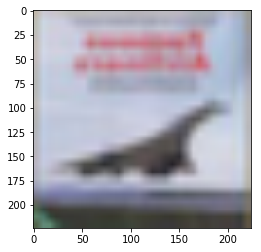

predicted: plane actual: plane


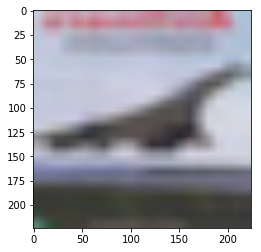

predicted: plane actual: plane


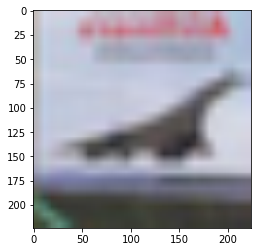

predicted: plane actual: plane


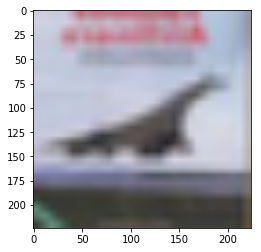

predicted: plane actual: plane


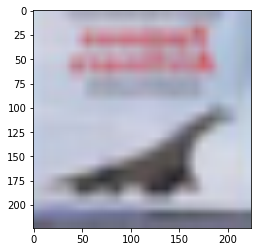

Top Incorrect predictions for class: plane
predicted: plane actual: frog


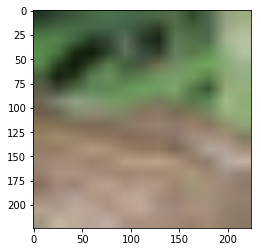

predicted: plane actual: cat


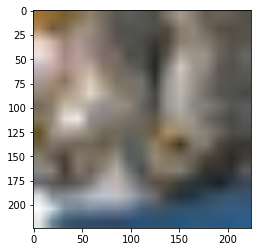

predicted: plane actual: frog


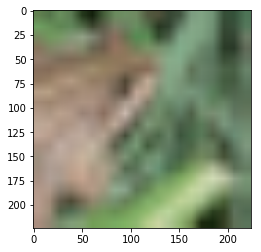

predicted: plane actual: cat


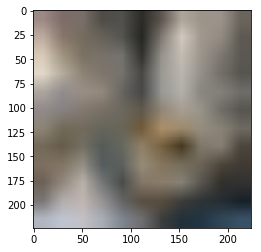

predicted: plane actual: frog


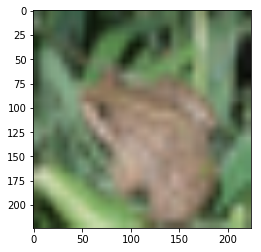

Top correct predictions for class: car
predicted: car actual: ship


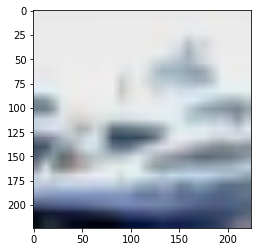

predicted: car actual: ship


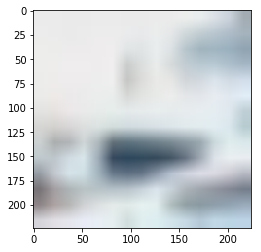

predicted: car actual: ship


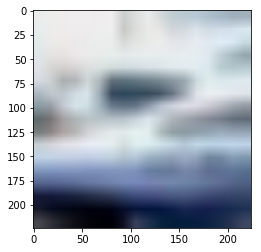

predicted: car actual: ship


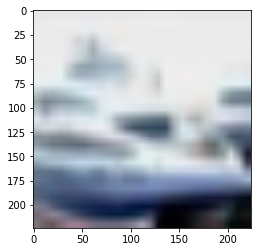

predicted: car actual: ship


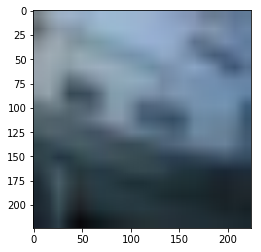

Top Incorrect predictions for class: car
predicted: car actual: cat


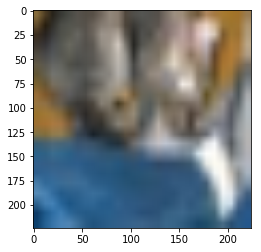

predicted: car actual: cat


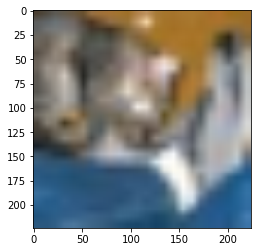

predicted: car actual: cat


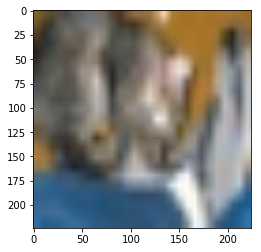

predicted: car actual: cat


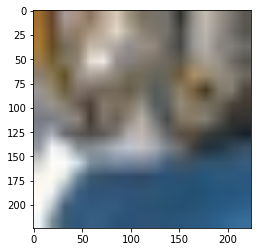

predicted: car actual: cat


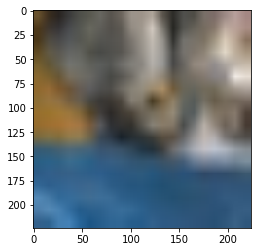

Top correct predictions for class: bird
predicted: bird actual: cat


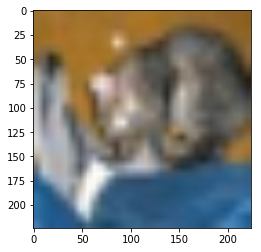

predicted: bird actual: frog


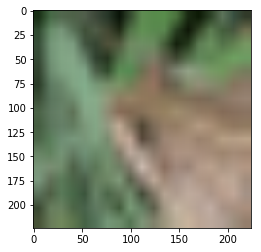

predicted: bird actual: frog


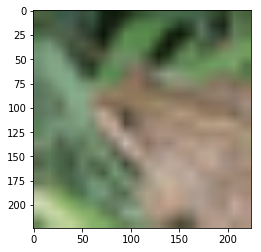

predicted: bird actual: frog


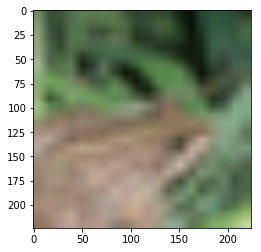

predicted: bird actual: cat


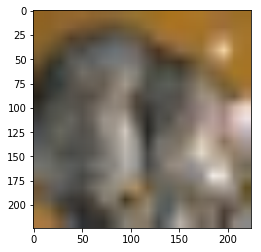

Top Incorrect predictions for class: bird
predicted: bird actual: ship


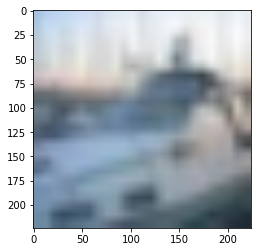

predicted: bird actual: cat


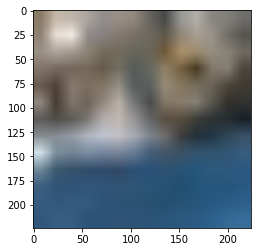

predicted: bird actual: ship


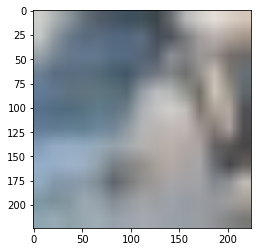

predicted: bird actual: ship


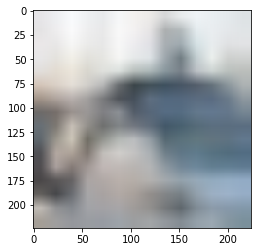

predicted: bird actual: cat


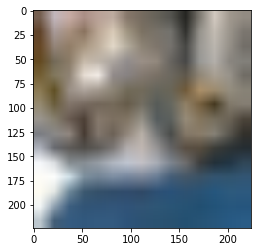

Top correct predictions for class: cat
predicted: cat actual: cat


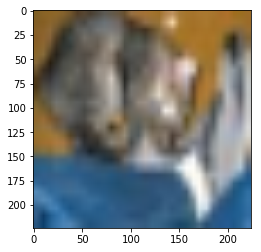

predicted: cat actual: cat


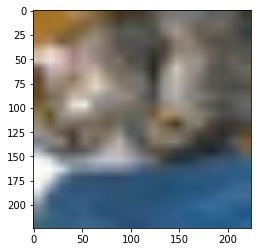

predicted: cat actual: cat


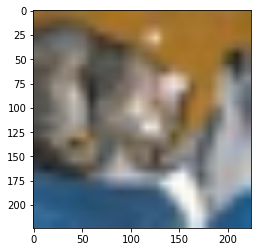

predicted: cat actual: cat


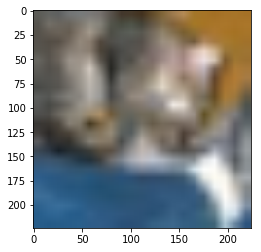

predicted: cat actual: cat


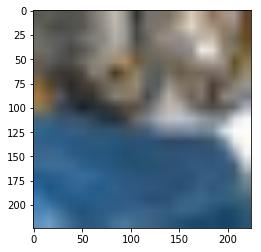

Top Incorrect predictions for class: cat
predicted: cat actual: ship


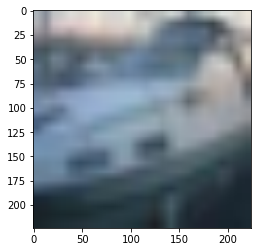

predicted: cat actual: plane


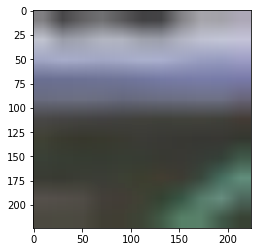

predicted: cat actual: ship


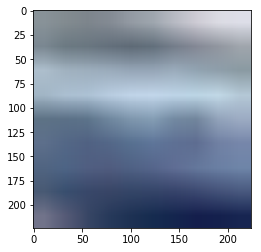

predicted: cat actual: frog


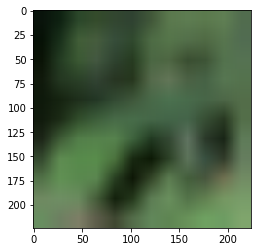

predicted: cat actual: ship


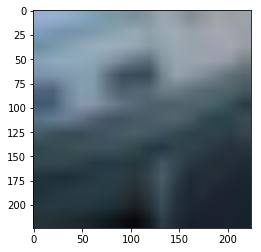

Top correct predictions for class: deer
predicted: deer actual: frog


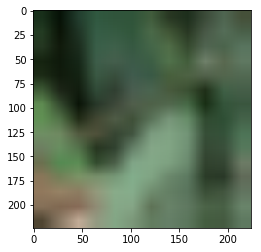

predicted: deer actual: frog


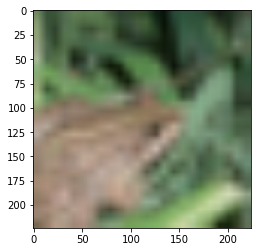

predicted: deer actual: frog


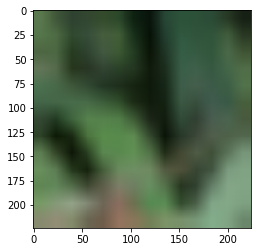

predicted: deer actual: frog


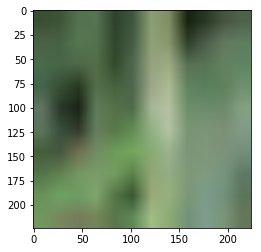

predicted: deer actual: frog


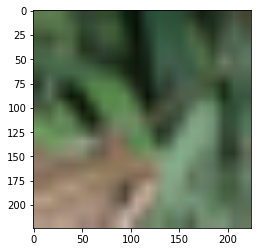

Top Incorrect predictions for class: deer
predicted: deer actual: ship


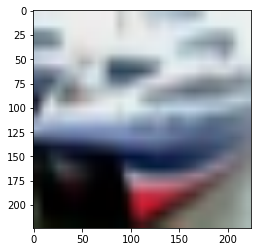

predicted: deer actual: ship


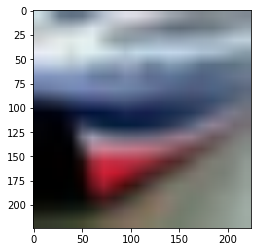

predicted: deer actual: ship


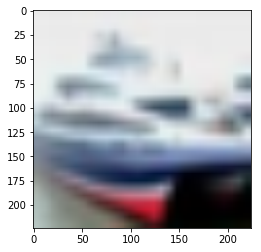

predicted: deer actual: ship


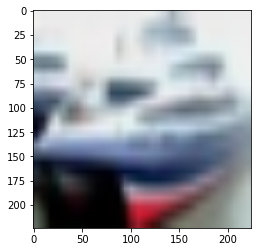

predicted: deer actual: ship


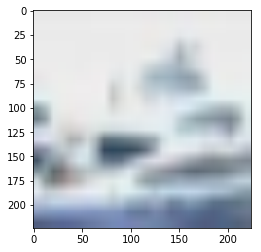

Top correct predictions for class: dog
predicted: dog actual: cat


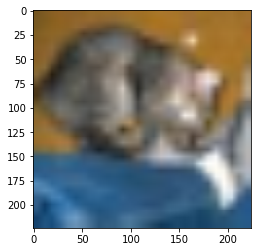

predicted: dog actual: cat


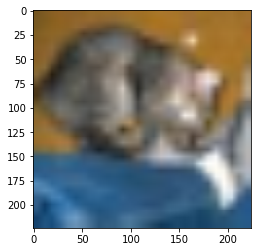

predicted: dog actual: cat


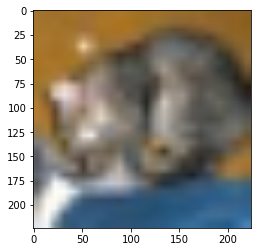

predicted: dog actual: cat


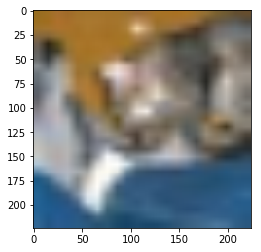

predicted: dog actual: cat


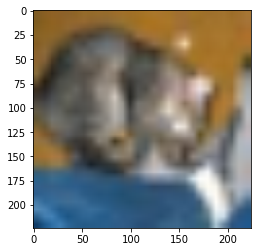

Top Incorrect predictions for class: dog
predicted: dog actual: plane


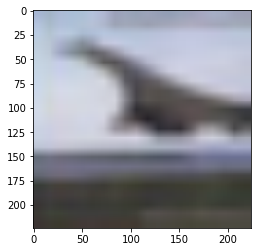

predicted: dog actual: ship


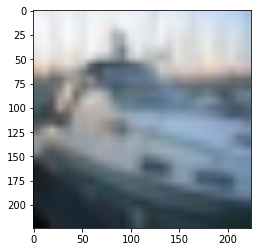

predicted: dog actual: ship


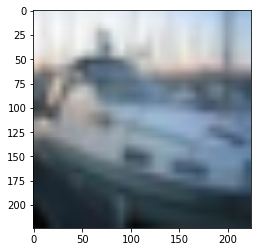

predicted: dog actual: plane


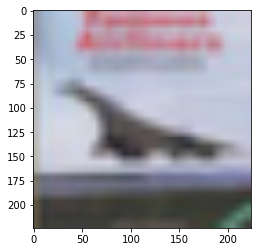

predicted: dog actual: plane


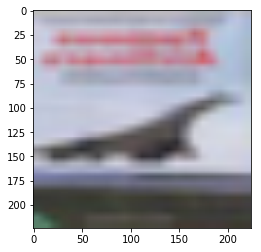

Top correct predictions for class: frog
predicted: frog actual: frog


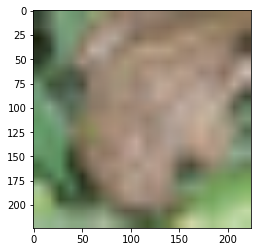

predicted: frog actual: frog


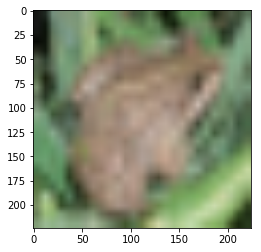

predicted: frog actual: frog


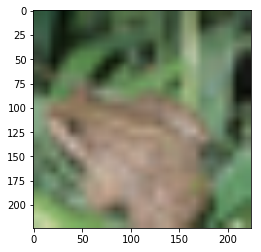

predicted: frog actual: frog


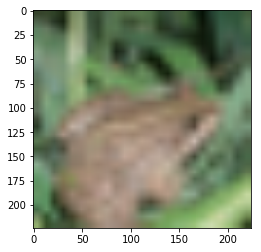

predicted: frog actual: frog


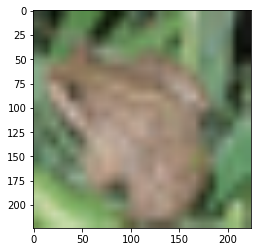

Top Incorrect predictions for class: frog
predicted: frog actual: ship


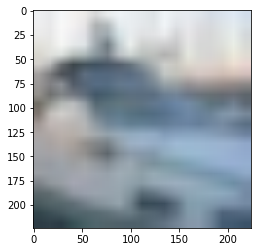

predicted: frog actual: ship


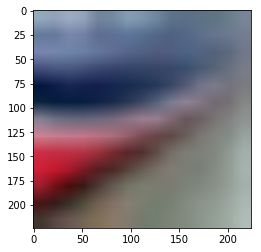

predicted: frog actual: ship


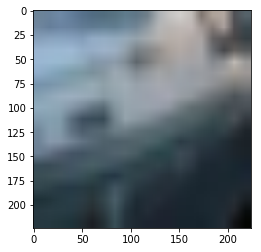

predicted: frog actual: ship


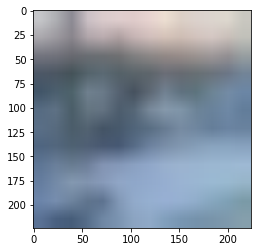

predicted: frog actual: plane


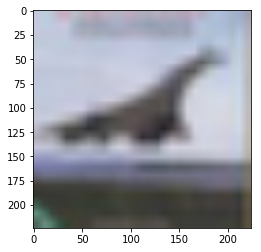

Top correct predictions for class: horse
predicted: horse actual: frog


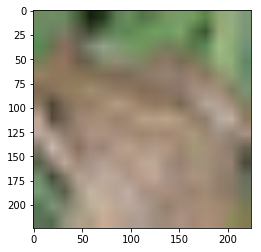

predicted: horse actual: plane


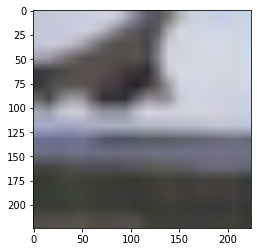

Top Incorrect predictions for class: horse
predicted: horse actual: plane


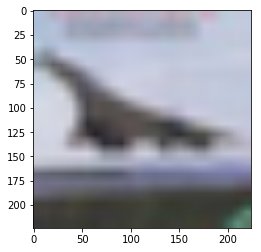

predicted: horse actual: cat


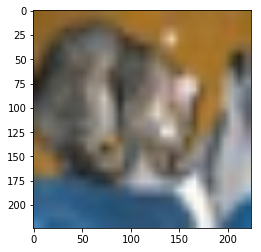

predicted: horse actual: frog


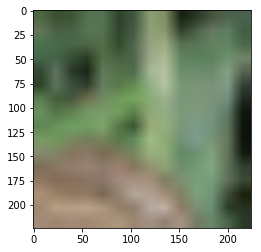

predicted: horse actual: cat


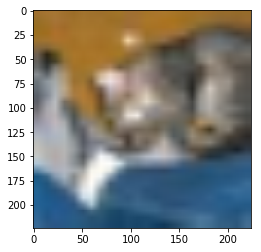

predicted: horse actual: ship


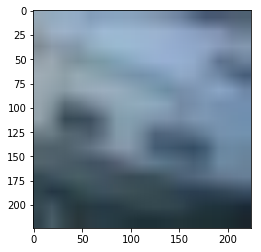

Top correct predictions for class: ship
predicted: ship actual: ship


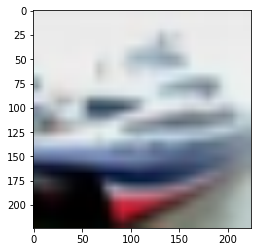

predicted: ship actual: ship


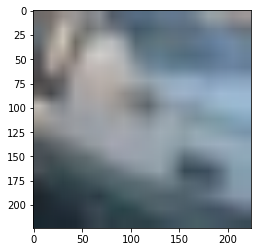

predicted: ship actual: ship


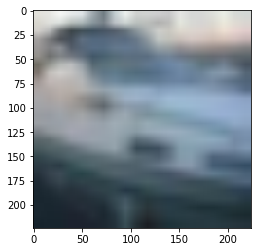

predicted: ship actual: plane


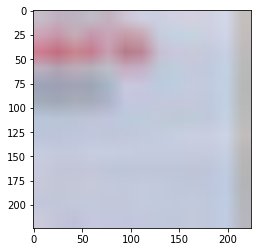

predicted: ship actual: ship


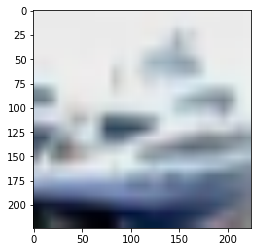

Top Incorrect predictions for class: ship
predicted: ship actual: frog


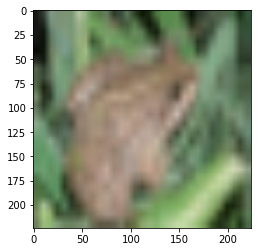

predicted: ship actual: cat


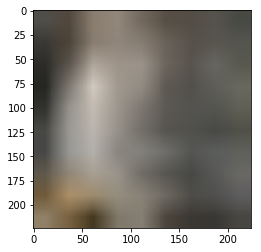

predicted: ship actual: cat


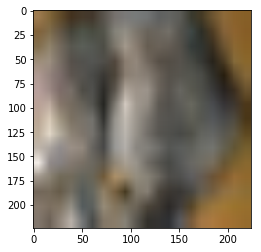

predicted: ship actual: cat


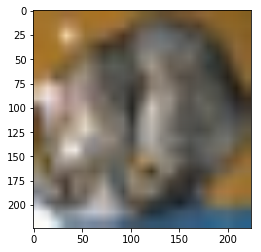

predicted: ship actual: frog


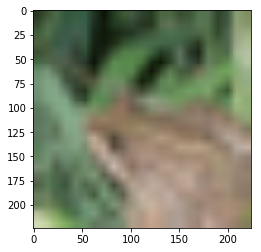

Top correct predictions for class: truck
predicted: truck actual: cat


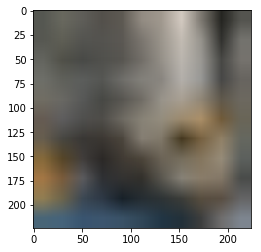

predicted: truck actual: plane


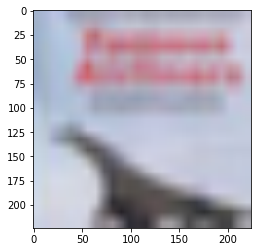

predicted: truck actual: ship


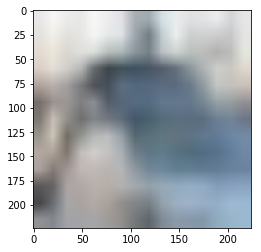

predicted: truck actual: plane


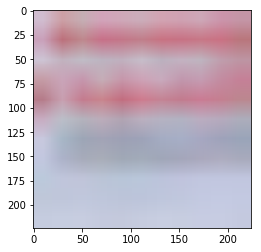

predicted: truck actual: plane


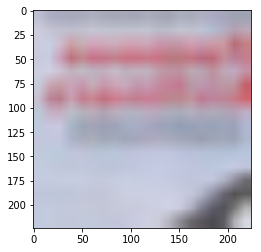

Top Incorrect predictions for class: truck
predicted: truck actual: frog


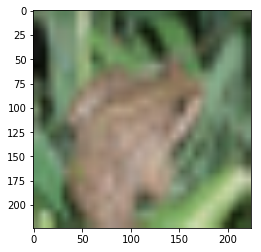

predicted: truck actual: frog


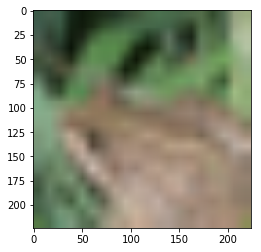

predicted: truck actual: frog


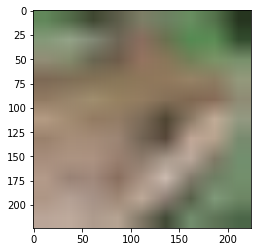

predicted: truck actual: frog


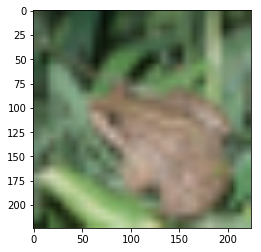

predicted: truck actual: frog


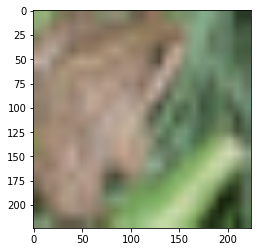

In [15]:
for i in range(10):
    print('Top correct predictions for class: {}'.format(classes[i]))
    Top5_Correct(model_conv,num_images=5,out=i)
    print('Top Incorrect predictions for class: {}'.format(classes[i]))
    Top5_Incorrect(model_conv,num_images=5,out=i)

## 1-3

### Finetuning the Convnet
- Load a pretrained model and reset final fully connected layer.
- Cross-entropy loss captures error on the target class. It discards any notion of errors that you might consider "false positive" and does not care how predicted probabilities are distributed other than predicted probability of the true class.


         Testing Dataset Accuracy : 87.08%

In [10]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.5)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.8878 Acc: 0.6908
test Loss: 0.6421 Acc: 0.7749

Epoch 1/24
----------
train Loss: 0.6241 Acc: 0.7843
test Loss: 0.5510 Acc: 0.8077

Epoch 2/24
----------
train Loss: 0.5563 Acc: 0.8088
test Loss: 0.5216 Acc: 0.8194

Epoch 3/24
----------
train Loss: 0.5187 Acc: 0.8206
test Loss: 0.5019 Acc: 0.8238

Epoch 4/24
----------
train Loss: 0.4934 Acc: 0.8281
test Loss: 0.4998 Acc: 0.8255

Epoch 5/24
----------
train Loss: 0.4784 Acc: 0.8343
test Loss: 0.4658 Acc: 0.8403

Epoch 6/24
----------
train Loss: 0.4493 Acc: 0.8436
test Loss: 0.4448 Acc: 0.8458

Epoch 7/24
----------
train Loss: 0.4059 Acc: 0.8592
test Loss: 0.4124 Acc: 0.8550

Epoch 8/24
----------
train Loss: 0.3817 Acc: 0.8696
test Loss: 0.4082 Acc: 0.8556

Epoch 9/24
----------
train Loss: 0.3863 Acc: 0.8672
test Loss: 0.4033 Acc: 0.8619

Epoch 10/24
----------
train Loss: 0.3767 Acc: 0.8691
test Loss: 0.3957 Acc: 0.8644

Epoch 11/24
----------
train Loss: 0.3697 Acc: 0.8726
test Loss: 0.3980 Acc

#### Prediction for model with finetuning

Top correct predictions for class: plane
predicted: plane actual: plane


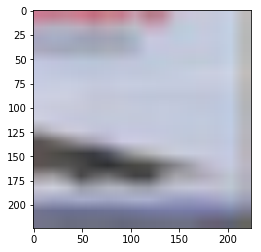

predicted: plane actual: plane


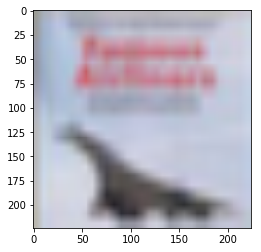

predicted: plane actual: plane


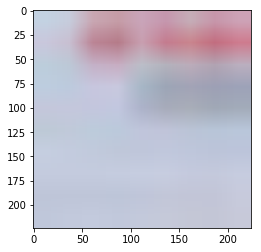

predicted: plane actual: plane


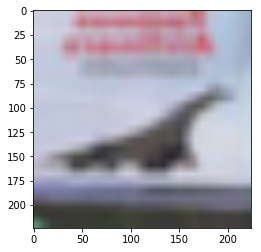

predicted: plane actual: plane


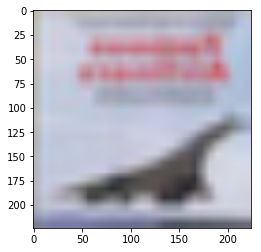

Top Incorrect predictions for class: plane
predicted: plane actual: cat


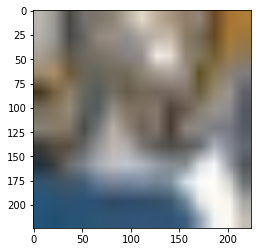

predicted: plane actual: frog


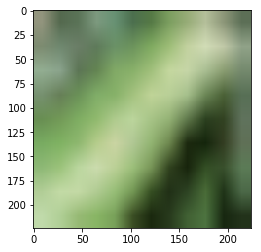

predicted: plane actual: cat


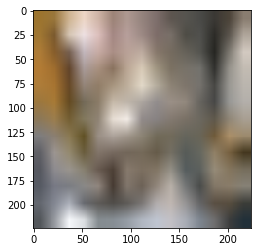

predicted: plane actual: frog


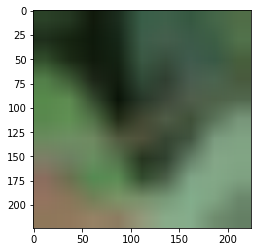

predicted: plane actual: frog


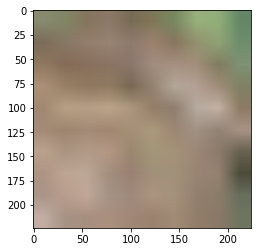

Top correct predictions for class: car
predicted: car actual: ship


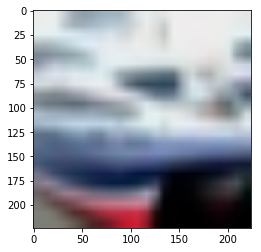

predicted: car actual: ship


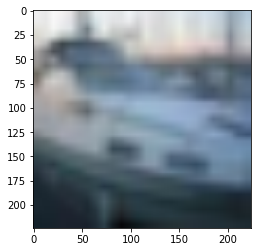

predicted: car actual: ship


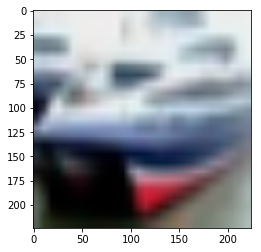

predicted: car actual: ship


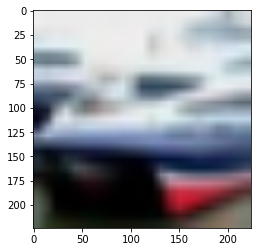

predicted: car actual: ship


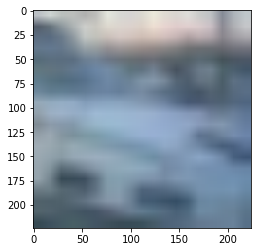

Top Incorrect predictions for class: car
predicted: car actual: frog


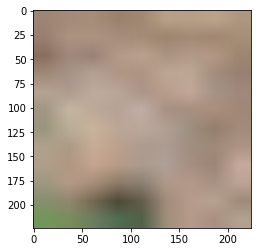

predicted: car actual: plane


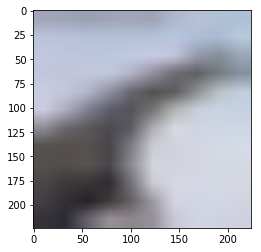

predicted: car actual: cat


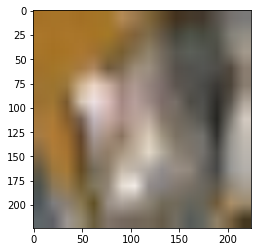

predicted: car actual: plane


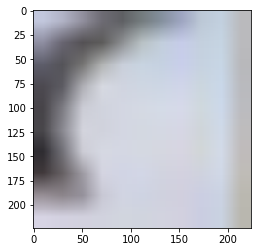

predicted: car actual: plane


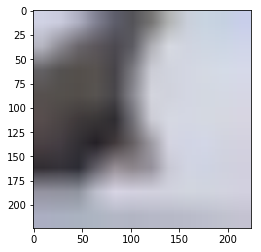

Top correct predictions for class: bird
predicted: bird actual: cat


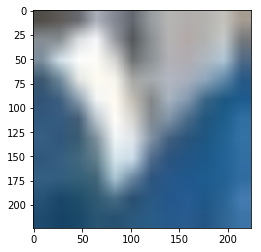

predicted: bird actual: frog


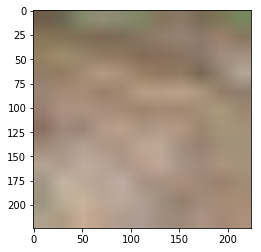

predicted: bird actual: cat


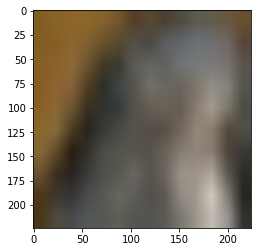

predicted: bird actual: frog


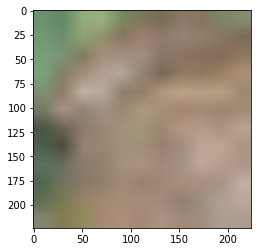

predicted: bird actual: cat


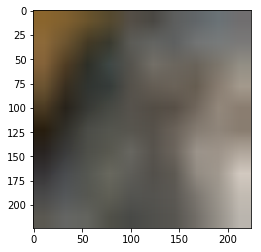

Top Incorrect predictions for class: bird
predicted: bird actual: ship


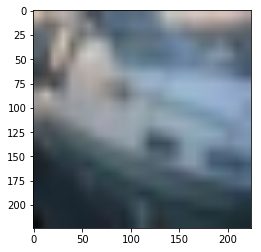

predicted: bird actual: ship


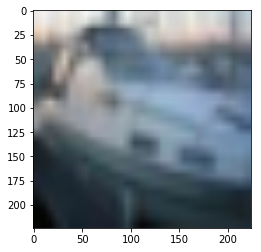

predicted: bird actual: ship


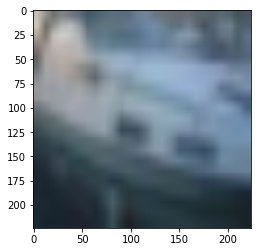

predicted: bird actual: ship


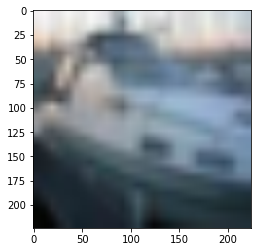

predicted: bird actual: ship


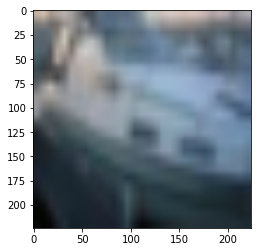

Top correct predictions for class: cat
predicted: cat actual: cat


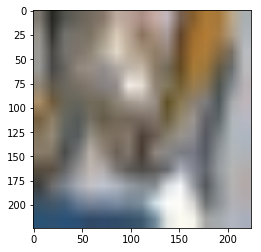

predicted: cat actual: cat


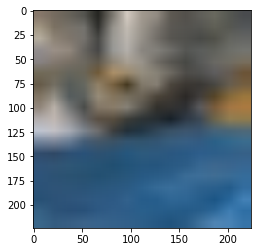

predicted: cat actual: cat


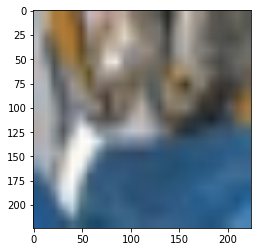

predicted: cat actual: cat


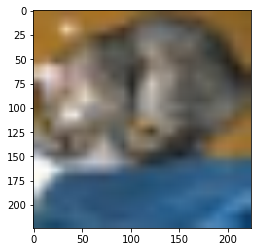

predicted: cat actual: cat


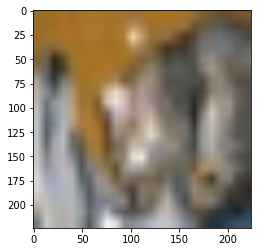

Top Incorrect predictions for class: cat
predicted: cat actual: ship


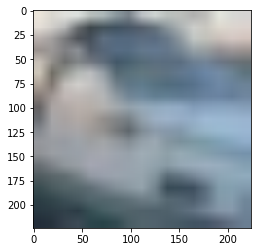

predicted: cat actual: ship


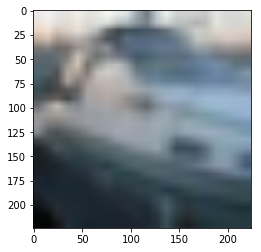

predicted: cat actual: ship


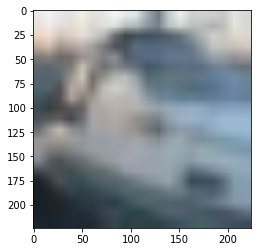

predicted: cat actual: ship


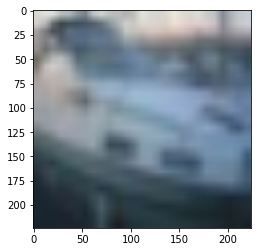

predicted: cat actual: ship


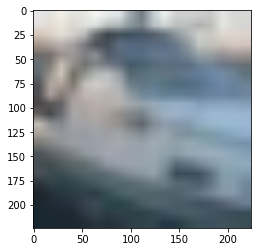

Top correct predictions for class: deer
predicted: deer actual: frog


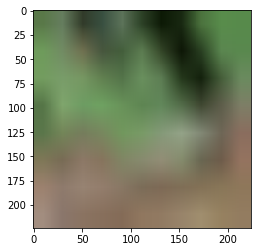

predicted: deer actual: frog


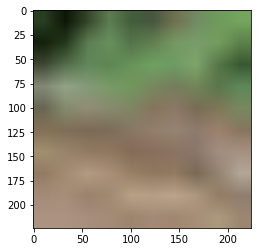

predicted: deer actual: frog


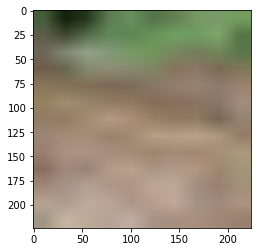

predicted: deer actual: frog


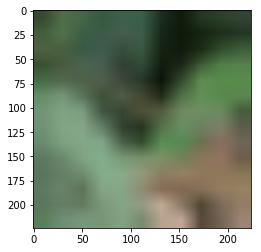

predicted: deer actual: frog


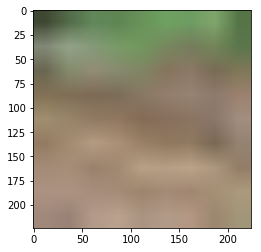

Top Incorrect predictions for class: deer
predicted: deer actual: ship


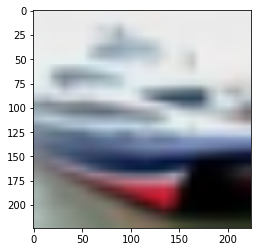

predicted: deer actual: ship


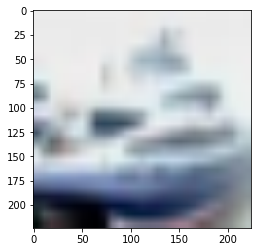

predicted: deer actual: ship


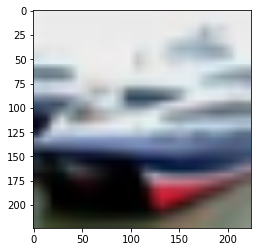

predicted: deer actual: ship


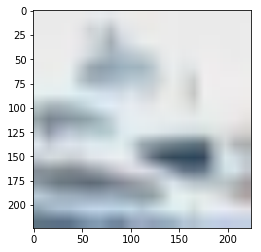

predicted: deer actual: ship


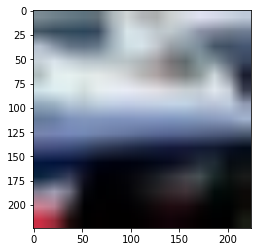

Top correct predictions for class: dog
Top Incorrect predictions for class: dog
predicted: dog actual: ship


<Figure size 432x288 with 0 Axes>

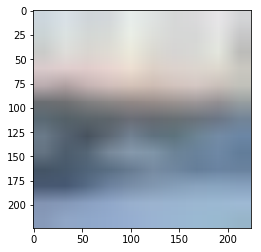

predicted: dog actual: ship


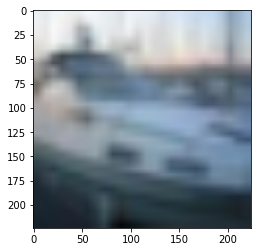

predicted: dog actual: ship


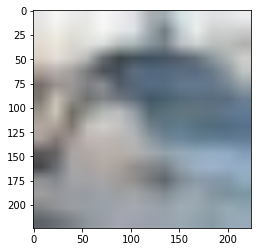

predicted: dog actual: ship


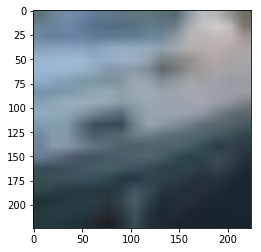

predicted: dog actual: ship


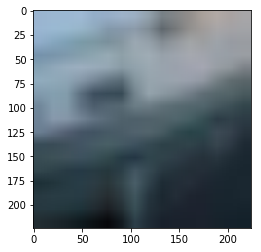

Top correct predictions for class: frog
predicted: frog actual: frog


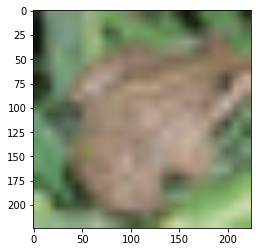

predicted: frog actual: frog


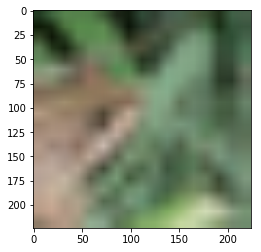

predicted: frog actual: frog


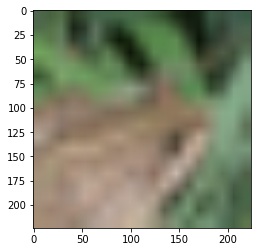

predicted: frog actual: frog


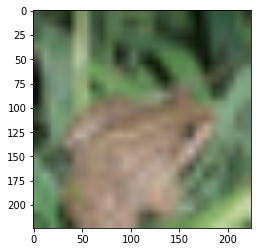

predicted: frog actual: frog


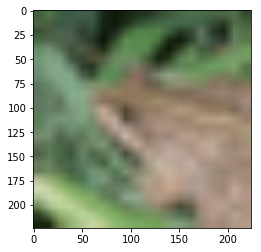

Top Incorrect predictions for class: frog
predicted: frog actual: ship


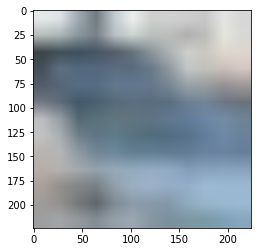

predicted: frog actual: ship


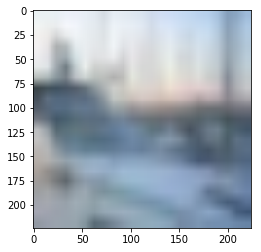

predicted: frog actual: ship


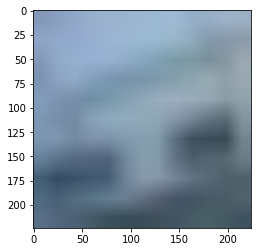

predicted: frog actual: plane


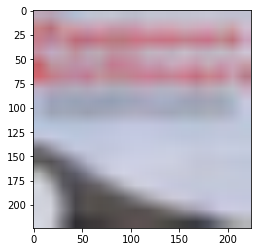

predicted: frog actual: plane


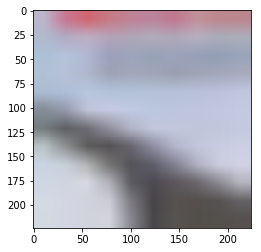

Top correct predictions for class: horse
Top Incorrect predictions for class: horse
predicted: horse actual: plane


<Figure size 432x288 with 0 Axes>

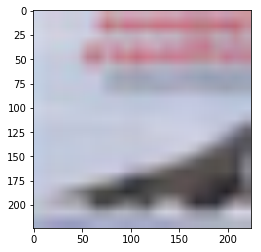

predicted: horse actual: cat


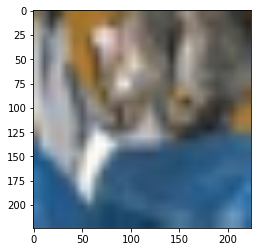

predicted: horse actual: plane


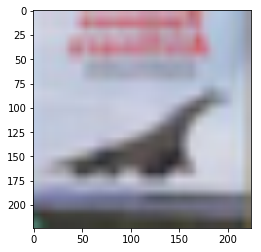

predicted: horse actual: cat


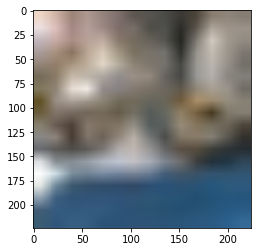

predicted: horse actual: plane


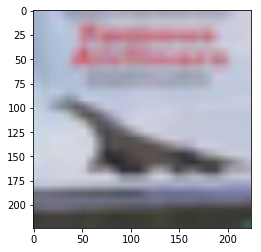

Top correct predictions for class: ship
predicted: ship actual: cat


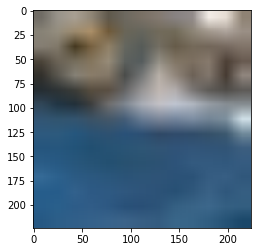

predicted: ship actual: ship


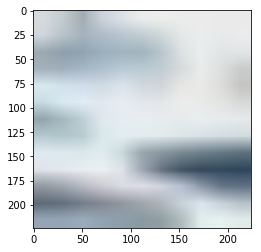

predicted: ship actual: plane


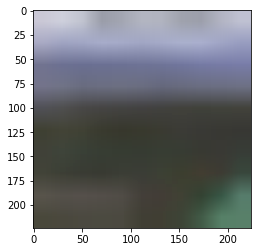

predicted: ship actual: ship


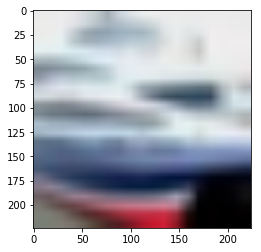

predicted: ship actual: plane


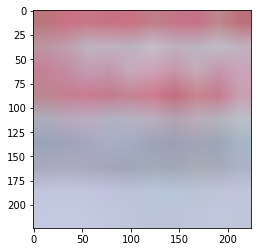

Top Incorrect predictions for class: ship
predicted: ship actual: cat


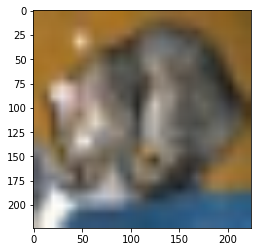

predicted: ship actual: frog


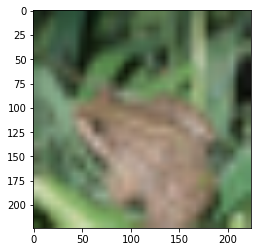

predicted: ship actual: frog


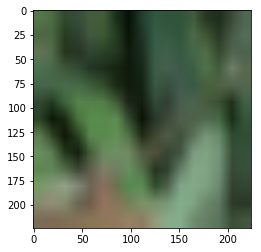

predicted: ship actual: frog


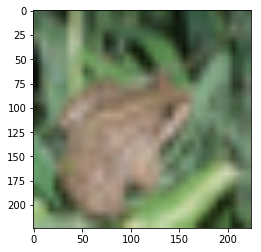

predicted: ship actual: cat


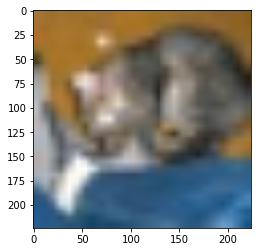

Top correct predictions for class: truck
predicted: truck actual: plane


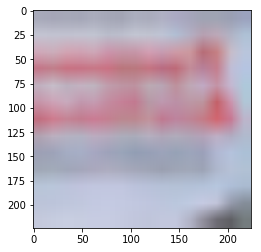

predicted: truck actual: frog


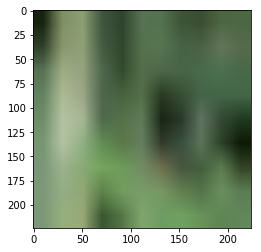

predicted: truck actual: plane


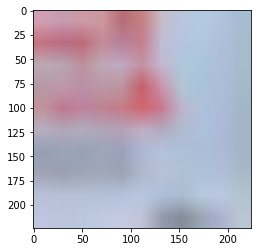

predicted: truck actual: plane


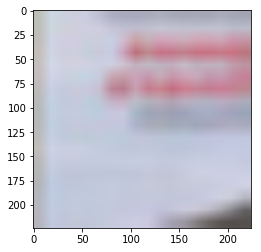

Traceback (most recent call last):
  File "/home/team5/anaconda3/lib/python3.7/multiprocessing/util.py", line 265, in _run_finalizers
    finalizer()
  File "/home/team5/anaconda3/lib/python3.7/multiprocessing/util.py", line 189, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/home/team5/anaconda3/lib/python3.7/shutil.py", line 489, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/home/team5/anaconda3/lib/python3.7/shutil.py", line 487, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-ehtyaiiy'


predicted: truck actual: plane


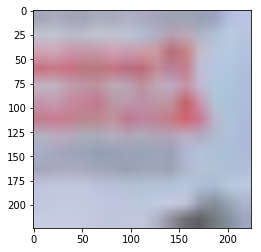

Top Incorrect predictions for class: truck
predicted: truck actual: frog


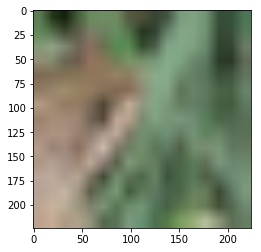

predicted: truck actual: cat


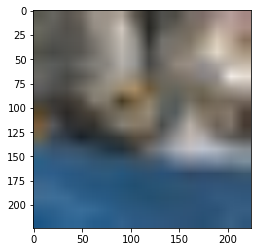

predicted: truck actual: frog


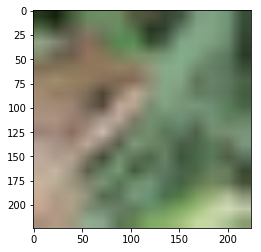

predicted: truck actual: cat


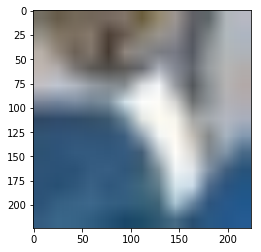

predicted: truck actual: cat


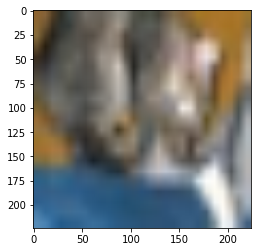

In [16]:
for i in range(10):
    print('Top correct predictions for class: {}'.format(classes[i]))
    Top5_Correct(model_ft,num_images=5,out=i)
    print('Top Incorrect predictions for class: {}'.format(classes[i]))
    Top5_Incorrect(model_ft,num_images=5,out=i)

# Q2 - Movie Embeddings

### Importing Packages

In [1]:
#importing packages
import re
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import warnings
warnings.filterwarnings("ignore")

## Q2 - 1 -Computing Target (Xij) dataset from movielens

### Loading Datasets

In [2]:
#Loading Datasets

ratings_ds = pd.read_csv('ml-latest-small/ratings.csv')
movies_ds = pd.read_csv('ml-latest-small/movies.csv')
tags_ds = pd.read_csv('ml-latest-small/tags.csv')
links_ds=  pd.read_csv('ml-latest-small/links.csv')

In [3]:
#adding column to ratings table to check whether user likes a movie or not

ratings_ds['Like']=np.where(ratings_ds['rating']>=4,1,0)

In [4]:
ratings_ds2 = ratings_ds.drop(['rating'],axis=1) #Dropping rating column

In [5]:
# creating a pivot using userId and movieId of ratings table

ratings_ds2_pivot = ratings_ds2.pivot(index = 'userId', columns ='movieId', values = 'Like').fillna(0)

In [6]:
ratings_ds2_pivot.shape#matrix created

(610, 9724)

In [7]:
#creating a co-occurence matrix , Each entry Xi,j is the number of users who like both movie i and j
rating_co_occ = ratings_ds2_pivot.T.dot(ratings_ds2_pivot)

In [8]:
rating_co_occ.head()

movieId  1       2       3       4       5       6       7       8       \
movieId                                                                   
1         147.0    21.0    11.0     0.0     7.0    27.0     7.0     1.0   
2          21.0    50.0     5.0     0.0     4.0     8.0     6.0     0.0   
3          11.0     5.0    18.0     0.0     4.0     4.0     5.0     1.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           7.0     4.0     4.0     0.0    12.0     3.0     4.0     1.0   

movieId  9       10       ...    193565  193567  193571  193573  193579  \
movieId                   ...                                             
1           4.0    19.0   ...       0.0     0.0     0.0     0.0     0.0   
2           0.0     9.0   ...       0.0     0.0     0.0     0.0     0.0   
3           2.0     3.0   ...       0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0   ...       0.0     0.0     0.0     0.0     0.0   
5           1.0     2.0   ...       0.0     0.0     0.0     0.0     0.0   

movieId  193581  193583  193585  193587  193609  
movieId                                          
1           0.0     0.0     0.0     0.0     0.0  
2           0.0     0.0     0.0     0.0     0.0  
3           0.0     0.0     0.0     0.0     0.0  
4           0.0     0.0     0.0     0.0     0.0  
5           0.0     0.0     0.0     0.0     0.0  

[5 rows x 9724 columns]

In [9]:
rating_co_occ.shape

(9724, 9724)

## Q2 - 2 - Creating and optimising the loss function

In [10]:
# converting rating_co_occ to matrix with diagonal elements as 0 to help in loss function

observed=rating_co_occ.as_matrix()
np.fill_diagonal(observed, 0)

In [11]:
# converting matrix to tensor using torch

observed = torch.from_numpy(rating_co_occ.as_matrix()).float()
observed

tensor([[ 0., 21., 11.,  ...,  0.,  0.,  0.],
        [21.,  0.,  5.,  ...,  0.,  0.,  0.],
        [11.,  5.,  0.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])

In [12]:
# creating a reference table with movieId, indexes of movies, movie name and genre

reference = rating_co_occ.reset_index()
reference = reference.merge(movies_ds, on='movieId', how='inner')

In [13]:
reference["movie"]=reference["title"].str.split('(',expand=True)[0].str.strip().str.lower()

In [14]:
reference.head(3)

movieId     1     2     3    4    5     6    7    8    9        ...         \
0        1   0.0  21.0  11.0  0.0  7.0  27.0  7.0  1.0  4.0        ...          
1        2  21.0   0.0   5.0  0.0  4.0   8.0  6.0  0.0  0.0        ...          
2        3  11.0   5.0   0.0  0.0  4.0   4.0  5.0  1.0  2.0        ...          

   193573  193579  193581  193583  193585  193587  193609  \
0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     title                                       genres  \
0         Toy Story (1995)  Adventure|Animation|Children|Comedy|Fantasy   
1           Jumanji (1995)                   Adventure|Children|Fantasy   
2  Grumpier Old Men (1995)                               Comedy|Romance   

              movie  
0         toy story  
1           jumanji  
2  grumpier old men  

[3 rows x 9728 columns]

In [15]:
# creating a One Hot Encoder matrix

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
data = reference["movieId"].unique()
values = array(data)
print(values)

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

inverted = label_encoder.inverse_transform([argmax(onehot_encoded[0, :])])
print(inverted)

[     1      2      3 ... 193585 193587 193609]
[   0    1    2 ... 9721 9722 9723]
[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]
[1]


In [16]:
#taking input OHE to NN module

movies_tensor = torch.from_numpy(onehot_encoded).float()
movies_tensor= torch.tensor(movies_tensor)
#movies_tensor.requires_grad

In [17]:
# Creating a model to calulculate loss function and optimise using gradient descent

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()





0 63482988.0
20 22604410.0
40 8410871.0
60 5171159.0
80 3722297.0
100 2772058.0
120 2110179.75
140 1642771.875
160 1306905.875
180 1058600.125
200 871652.125


#### Loss of cost function after 200 iterations is:

In [18]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

<Figure size 640x480 with 1 Axes>

## Q2 - 3 - Recommending top 10 movies

In [19]:
# Creating a prediction function to give movie recommendations

def prediction(moviename):
    
    #getting tensor for movie
    moviename= moviename.lower()
    idx = reference[reference["movie"]== moviename].index[0]   
    movie = movies_tensor[idx]
    movie = movie.reshape(1,movie.shape[0])
    
    #storing weight vector from model
    for name, param in model.named_parameters():
        weight_vector = param
    
    # prediction for given movie
    movie_i = model(movie)
    pred = torch.mm(movie_i,weight_vector)
    
    # movie index value sorted from min to max for predicted score values
    
    pred_idx = (-np.asanyarray(pred[0].detach().numpy())).argsort()[:10]
    
    # Getting title of recommended movie from Reference Dataframe
    recommendations = reference["title"].iloc[pred_idx]
    
    return recommendations
    

In [20]:
# Creating a function to see top 10 movies recommendation for a movie in Xij matrix

def observed_reco(moviename):
    
    # Getting Index of Movie from MovieId
    idx = reference[reference["movie"]== moviename].index[0]
    
    # Sorting top 10 movie indexes from Co-Occurence Matrix
    obs_idx = (-np.asanyarray(rating_co_occ.iloc[idx])).argsort()[:10]
    
    # Getting movie title from top 10 movie indexes
    recommendations = reference["title"].iloc[obs_idx]
    
    return recommendations

#### Top 10 movie prediction for Apollo 13

In [23]:
display("Model Predictions:",prediction("APOLLO 13"),"Actual Predictions:", observed_reco("apollo 13"))

'Model Predictions:'

314                          Forrest Gump (1994)
277             Shawshank Redemption, The (1994)
257                          Pulp Fiction (1994)
510             Silence of the Lambs, The (1991)
123                             Apollo 13 (1995)
97                             Braveheart (1995)
418                         Jurassic Park (1993)
398                         Fugitive, The (1993)
461                      Schindler's List (1993)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

'Actual Predictions:'

277             Shawshank Redemption, The (1994)
314                          Forrest Gump (1994)
257                          Pulp Fiction (1994)
418                         Jurassic Park (1993)
510             Silence of the Lambs, The (1991)
398                         Fugitive, The (1993)
97                             Braveheart (1995)
461                      Schindler's List (1993)
507            Terminator 2: Judgment Day (1991)
224    Star Wars: Episode IV - A New Hope (1977)
Name: title, dtype: object

#### Top 10 movie recommendations for Toy Story

In [24]:
display("Model Predictions:",prediction("toy story"),"Actual Predictions:", observed_reco("toy story"))

'Model Predictions:'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
224             Star Wars: Episode IV - A New Hope (1977)
1938                                   Matrix, The (1999)
897     Star Wars: Episode V - The Empire Strikes Back...
899     Raiders of the Lost Ark (Indiana Jones and the...
0                                        Toy Story (1995)
418                                  Jurassic Park (1993)
Name: title, dtype: object

'Actual Predictions:'

277                      Shawshank Redemption, The (1994)
314                                   Forrest Gump (1994)
224             Star Wars: Episode IV - A New Hope (1977)
257                                   Pulp Fiction (1994)
510                      Silence of the Lambs, The (1991)
897     Star Wars: Episode V - The Empire Strikes Back...
1938                                   Matrix, The (1999)
418                                  Jurassic Park (1993)
899     Raiders of the Lost Ark (Indiana Jones and the...
910     Star Wars: Episode VI - Return of the Jedi (1983)
Name: title, dtype: object

#### Top 10 movie predictions for Home Alone

In [25]:
display("Model Predictions:",prediction("home alone"),"Actual Predictions:", observed_reco("home alone"))

'Model Predictions:'

314                           Forrest Gump (1994)
504                             Home Alone (1990)
418                          Jurassic Park (1993)
277              Shawshank Redemption, The (1994)
506                                Aladdin (1992)
322                         Lion King, The (1994)
1938                           Matrix, The (1999)
224     Star Wars: Episode IV - A New Hope (1977)
0                                Toy Story (1995)
510              Silence of the Lambs, The (1991)
Name: title, dtype: object

'Actual Predictions:'

314                   Forrest Gump (1994)
418                  Jurassic Park (1993)
277      Shawshank Redemption, The (1994)
506                        Aladdin (1992)
322                 Lion King, The (1994)
507     Terminator 2: Judgment Day (1991)
0                        Toy Story (1995)
510      Silence of the Lambs, The (1991)
1938                   Matrix, The (1999)
257                   Pulp Fiction (1994)
Name: title, dtype: object

### Changing Learning Rates:

#### Increasing the learning rate by 100 times to 1

In [26]:
# Changing learning rate to 1

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 1
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()




0 63482960.0
20 8544730112.0
40 797102976.0
60 76067680.0
80 17497732.0
100 10002587.0
120 7385810.0
140 5871215.0
160 4855597.0
180 4121301.75
200 3560509.25


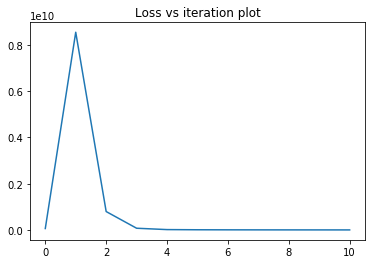

In [27]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

#### The predictions for Apollo 13 show that these are similar to the actual predictions but still the recommedations are a little different from the actual predictions and from what we got when the learning rate was 0.01

In [58]:
prediction("apollo 13")

4607                             Kill Bill: Vol. 1 (2003)
827                                 Reservoir Dogs (1992)
123                                      Apollo 13 (1995)
224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
3814                                    Spider-Man (2002)
3633    Lord of the Rings: The Fellowship of the Ring,...
4131        Lord of the Rings: The Two Towers, The (2002)
2729                               Blazing Saddles (1974)
1260                             Starship Troopers (1997)
Name: title, dtype: object

#### Lowering the learning rate by 100 times to 0.0001

In [55]:
# Lowering the learning rate by 100 times to 0.0001

import torch
torch.nn.Linear

# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in,H, D_out = 9724, 300, 9724
loss_array =[]
# Create random Tensors to hold inputs and outputs
x = movies_tensor
y = observed

# Use the nn package to define our model as a sequence of layers. nn.Sequential
# is a Module which contains other Modules, and applies them in sequence to
# produce its output. Each Linear Module computes output from input using a
# linear function, and holds internal Tensors for its weight and bias.


model = torch.nn.Sequential(
    torch.nn.Linear(D_in, H,bias=0)
)

# The nn package also contains definitions of popular loss functions; in this
# case we will use Mean Squared Error (MSE) as our loss function.
loss_fn = torch.nn.MSELoss(reduction="sum")

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(201):
    # Forward pass: compute predicted y by passing x to the model.
    v_i = model(x)
    v_j = v_i.t()
    y_pred = torch.mm(v_i,v_j)
    
    
    ind = np.diag_indices(y_pred.shape[0])
    y_pred[ind[0], ind[1]] = torch.zeros(y_pred.shape[0])
    y_pred

    # Compute and print loss.
    loss = loss_fn(y_pred, y)
    if t % 20 == 0:
        print(t, loss.item())
        loss_array.append(loss)
    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()




0 63482976.0
20 63456452.0
40 63351876.0
60 63136012.0
80 62801520.0
100 62358824.0
120 61824716.0
140 61216272.0
160 60548940.0
180 59835288.0
200 59085028.0


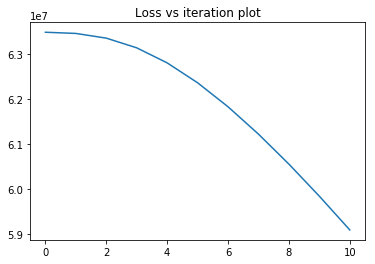

In [57]:
# plot of loss vs interations
import matplotlib.pyplot as plt
plt.title("Loss vs iteration plot")
plt.plot(loss_array)
plt.show()

#### The predictions for Apollo 13 will show that these are much different than the actual predictions and also from the one we have recommended when the learning rate is 0.01

In [56]:
prediction("apollo 13")

4607                             Kill Bill: Vol. 1 (2003)
827                                 Reservoir Dogs (1992)
123                                      Apollo 13 (1995)
224             Star Wars: Episode IV - A New Hope (1977)
314                                   Forrest Gump (1994)
3814                                    Spider-Man (2002)
3633    Lord of the Rings: The Fellowship of the Ring,...
4131        Lord of the Rings: The Two Towers, The (2002)
2729                               Blazing Saddles (1974)
1260                             Starship Troopers (1997)
Name: title, dtype: object

### Our Analysis

#### Learning rate scales the magnitude of our weights in order to minimize the network's loss function. If learning rate is set to a high value it would keep bouncing as it nears the optimal point and my not reach the optimal point and thus give us incorrect recommendations. Whereas, if learning rate is too small, then training will progress very slowly as we are making very tiny updates to the weight and there is a chance to get stuck in local minima and our gradient descent function will give constant loss with increase in iterations, resulting in high cost and incorrect recommendations.